# Feature Engineering & Modelling - Multiclass Classification

## 1. Data & Package Import

In [33]:
# Packages Import
import pandas as pd 
import numpy as np
import skimpy as skim
import matplotlib.pyplot as plt
import seaborn as sns
import os 

import warnings 
warnings.filterwarnings("ignore")

import functions as ft
import importlib

import sklearn.preprocessing as pre 
import sklearn.metrics as mt
import sklearn.linear_model as lm 
import sklearn.model_selection as ms
import sklearn.feature_selection as fs
import sklearn.ensemble as ens
import sklearn.impute as imp

import xgboost as xgb

from skopt import BayesSearchCV
from skopt.space import Real, Integer,Categorical

import catboost 
import lightgbm as lgb

import optuna

In [34]:
# Reload of the functions script
importlib.reload(ft)

<module 'functions' from '/Users/ezequielhurtado/Desktop/PROJETS/M2/multiclass-classification/scripts/functions.py'>

In [35]:
# Data loading
df_train_v0 = pd.read_csv("../data/train.csv", delimiter = ",",header = 0)
df_test_v0 = pd.read_csv("../data/test.csv")

## 2. Feature Engineering

### 2.1. Split & Statistical Tests

In [36]:
# Data Split based on our Train Data as Test does not have a Target Variable where
# we could have calculated the Log Loss. 
df_train, df_test = ms.train_test_split(df_train_v0, test_size = 0.2)

In [37]:
# Variables list
df_quant = df_train.select_dtypes(exclude ='object').columns[:-1]
df_qual = df_train.select_dtypes(include ='object').columns.insert(0,"Stage")

In [38]:
# Methode lié à la mediane
# df_train_clean_quant , df_test_clean_quant = ft.continuous_cleaning(df_train, df_test, df_quant)

In [39]:
# DataFrame containing quantitative variables only. 
df_train_quant = df_train[df_quant[1:]]
df_test_quant = df_test[df_quant[1:]]

In [40]:
# Data Cleaning through KNNs method
knn_clean = imp.KNNImputer()
df_train_clean_quant = pd.DataFrame(knn_clean.fit_transform(df_train_quant))
df_test_clean_quant = pd.DataFrame(knn_clean.transform(df_test_quant))

In [41]:
# Data Cleaning on categorical variables based on our script. 
df_train_clean_quali , df_test_clean_quali = ft.categorical_cleaning(df_train[df_qual],
                                                                     df_test[df_qual])

### 2.2. Encoding

In [42]:
# One Hot Encoding on categorical variables.
ohe = pre.OneHotEncoder(drop = 'first',sparse_output=False)
df_train_quali_ohe = pd.DataFrame(ohe.fit_transform(df_train_clean_quali[df_qual[1:-1]]),
                                  columns= ohe.get_feature_names_out(),
                                  index = df_train_clean_quali.index)

df_test_quali_ohe = pd.DataFrame(ohe.transform(df_test_clean_quali[df_qual[1:-1]]),
                                 columns= ohe.get_feature_names_out(),
                                 index = df_test_clean_quali.index)


In [43]:
df_train_quali_ohe["Stage"] = df_train_clean_quali["Stage"].map({1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3})
df_test_quali_ohe["Stage"] = df_test_clean_quali["Stage"].map({1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3})


### 2.3. Standardization

In [44]:
# Normal Standardization 
normalize = pre.StandardScaler()
df_train_quant_ss = pd.DataFrame(normalize.fit_transform(df_train_clean_quant),
                                 columns = df_train_quant.columns,
                                 index =df_train_quant.index)

df_test_quant_ss = pd.DataFrame(normalize.transform(df_test_clean_quant),
                                columns = df_test_quant.columns,
                                index = df_test_quant.index)

In [45]:
# Power Transformer : Standardization through Yeo Johnson (Negative Values are accepted)
ptransformer = pre.PowerTransformer(method = 'yeo-johnson')
df_train_quant_pt = pd.DataFrame(ptransformer.fit_transform(df_train_clean_quant),
                                 columns= df_train_quant.columns,
                                 index = df_train_quant.index)

df_test_quant_pt = pd.DataFrame(ptransformer.transform(df_test_clean_quant),
                                columns= df_test_quant.columns, 
                                index= df_test_quant.index)

### 2.4. Merge

In [46]:
# Merging of all the DataFrames when Standar Scaler is used
df_train_clean = df_train_quant_ss.merge(df_train_quali_ohe,
                                         how = 'inner',
                                         left_index=True,
                                         right_index=True)

df_test_clean = df_test_quant_ss.merge(df_test_quali_ohe,
                                       how = 'inner',
                                       left_index=True,
                                       right_index=True)

In [47]:
# Merging of all the DataFrames when Power Transformer is used
df_train_clean = df_train_quant_pt.merge(df_train_quali_ohe,
                                         how = 'inner',
                                         left_index=True,
                                         right_index=True)

df_test_clean = df_test_quant_pt.merge(df_test_quali_ohe,
                                       how = 'inner',
                                       left_index=True,
                                       right_index=True)

In [48]:
# Merging of all the DataFrames with the Target Variable.
df_train_final = df_train_clean.merge(df_train_clean_quali["Status"],
                                      how = 'inner',
                                      left_index=True,
                                      right_index=True)

df_test_final = df_test_clean.merge(df_test_clean_quali["Status"],
                                    how = 'inner',
                                    left_index=True,
                                    right_index=True)

## 3. Modelling

In [49]:
# We split our DataFrames in X and Y
X_train = df_train_final.drop(columns = 'Status')
X_test = df_test_final.drop(columns = 'Status')

Y_train = df_train_final['Status'].map({'C': 0, 'CL': 1, 'D': 2})
Y_test = df_test_final['Status'].map({'C': 0, 'CL': 1, 'D': 2})

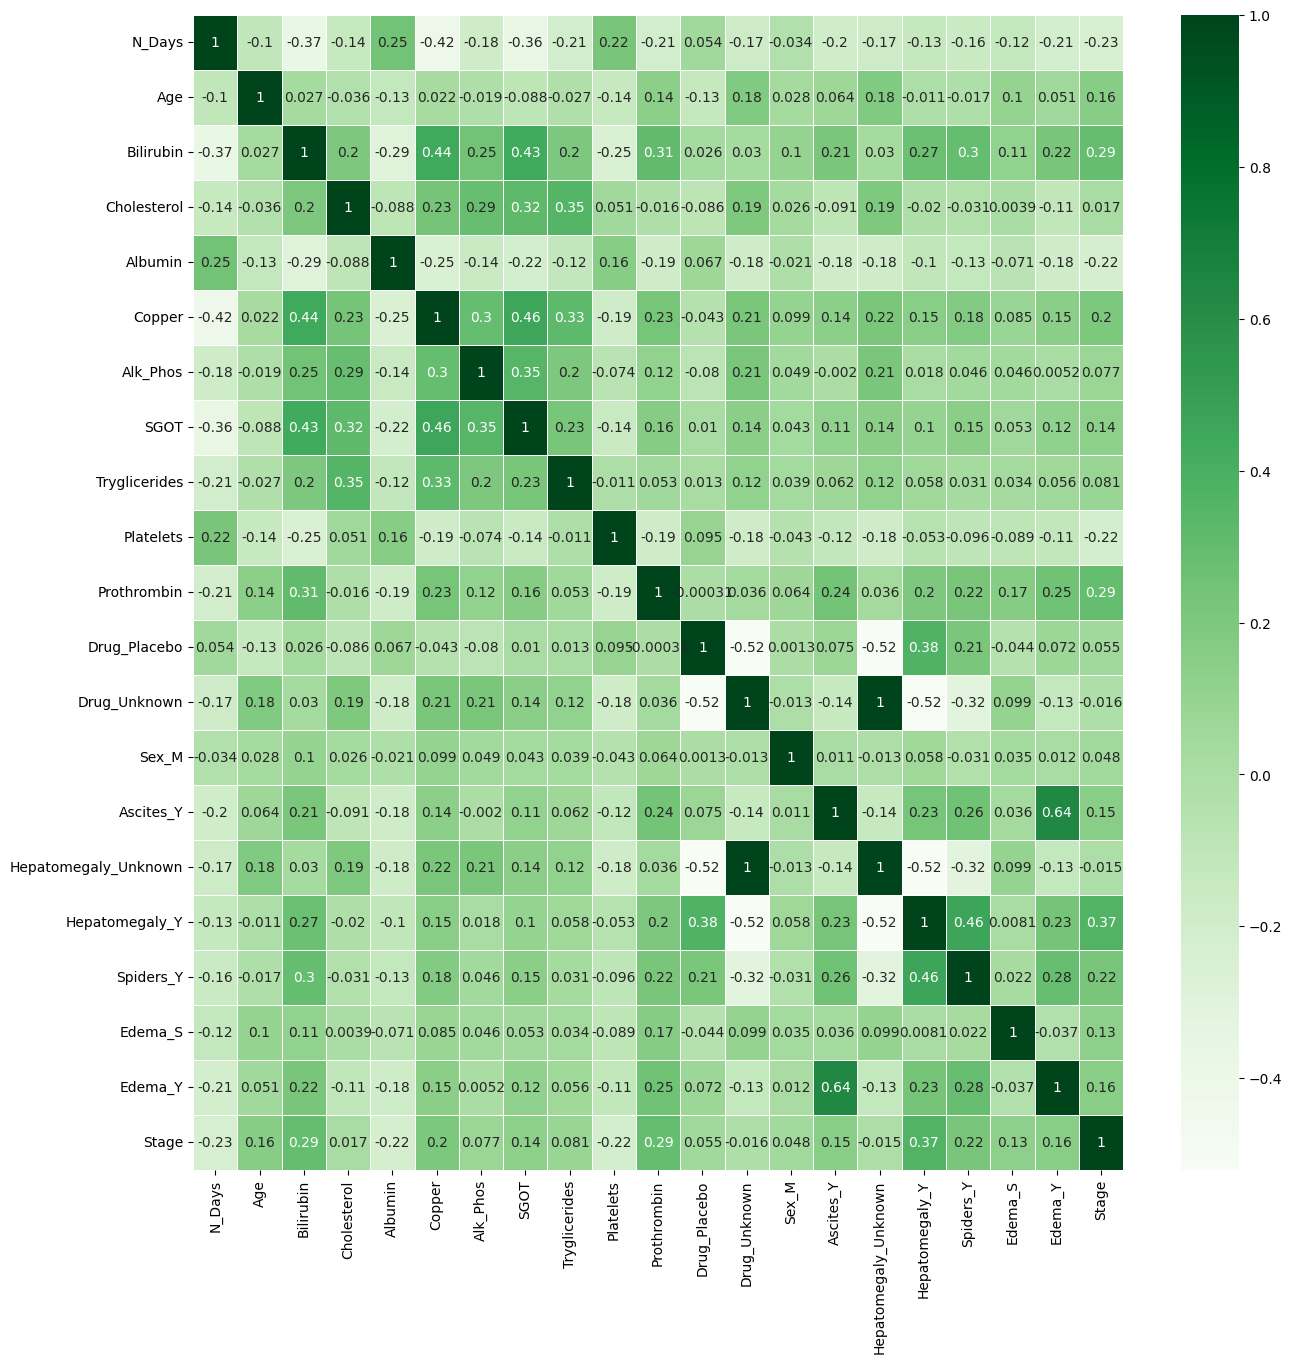

In [50]:
# Correlation matrix (Hepatomegaly Unknown & Drug Unknown have a correlation of 1 - Hepatomegaly Unknown will be deleted)
plt.figure(figsize = (15,15))
sns.heatmap(X_train.corr(), annot = True, linewidth=.5, cmap = 'Greens')
plt.show()

In [51]:
# We drop one of the variables that are highly correlated.
X_train_clean = X_train.copy().drop(columns = "Hepatomegaly_Unknown")
X_test_clean = X_test.copy().drop(columns = "Hepatomegaly_Unknown")

### 3.1. Base Model Logistic Regression

In [52]:
model = lm.LogisticRegression(multi_class='multinomial',
                              solver='newton-cg',
                              max_iter=10000)

model.fit(X_train_clean, Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'newton-cg'
,max_iter,10000
,multi_class,'multinomial'


In [53]:
y_pred_proba_train = model.predict_proba(X_train_clean)
y_pred_proba_test = model.predict_proba(X_test_clean)

logloss_train = mt.log_loss(Y_train, y_pred_proba_train)
print(f"Log Loss: {logloss_train}")

logloss_test = mt.log_loss(Y_test, y_pred_proba_test)
print(f"Log Loss: {logloss_test}")

Log Loss: 0.43829912458324394
Log Loss: 0.4346527809659674


### 3.2. XGBoost Model

In [54]:
def objective(trial):
    parameters = {
        "booster" : "gbtree",
        "learning_rate" : trial.suggest_float("learning_rate",0.1,1,log = True),
        "max_depth" : trial.suggest_int("max_depth", 2,11),
        "alpha" : trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float('subsample', 0.1, 1.0),
        "n_estimators": trial.suggest_int('n_estimators', 250, 1000),
        "objective" : "multi:softprob",
        "eval_metric" : "mlogloss",
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15)}
    
    model_xgb = xgb.XGBClassifier(**parameters)
    model_xgb.fit(X_train_clean,Y_train)
    Y_pres_proba_test = model_xgb.predict_proba(X_test_clean)
    logloss_test = mt.log_loss(Y_test,Y_pres_proba_test)    

    return logloss_test

In [57]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=100,n_jobs=-1)

print("Best hyperparameters:", study.best_params)
print("Best value:", study.best_value)

[I 2026-02-18 21:21:30,197] A new study created in memory with name: no-name-3b991c9e-73f4-4f36-b531-d11afd4198ae
[I 2026-02-18 21:22:09,964] Trial 11 finished with value: 0.4113973061172688 and parameters: {'learning_rate': 0.16175084844390486, 'max_depth': 5, 'alpha': 0.0004102456421494398, 'subsample': 0.10669092988959719, 'n_estimators': 250, 'min_child_weight': 7}. Best is trial 11 with value: 0.4113973061172688.
[I 2026-02-18 21:22:12,751] Trial 7 finished with value: 0.3896375235361281 and parameters: {'learning_rate': 0.30631823988315043, 'max_depth': 2, 'alpha': 6.0902716824373955e-05, 'subsample': 0.7121649572758846, 'n_estimators': 538, 'min_child_weight': 3}. Best is trial 7 with value: 0.3896375235361281.
[I 2026-02-18 21:22:24,190] Trial 4 finished with value: 0.37770988546599105 and parameters: {'learning_rate': 0.13934527944600944, 'max_depth': 2, 'alpha': 1.0093109622073293e-05, 'subsample': 0.456573771561376, 'n_estimators': 679, 'min_child_weight': 10}. Best is trial

Best hyperparameters: {'learning_rate': 0.10697150001167716, 'max_depth': 2, 'alpha': 4.7577734647235295e-06, 'subsample': 0.7029366920525139, 'n_estimators': 667, 'min_child_weight': 11}
Best value: 0.37525755135000777


In [ ]:
model_xgb = xgb.XGBClassifier(learning_rate = 0.1164039264729041,
                              max_depth = 2,
                              alpha = 0.0009553035424630976,
                              # lambda = 3.060483457130935e-06,
                              # gamma = 2.1828457278860258e-07,
                              subsample = 0.8803379149700773,
                              n_estimators=928,
                              min_child_weight= 4)

model_xgb.fit(X_train_clean,Y_train)
Y_pres_proba_test = model_xgb.predict_proba(X_test_clean)
logloss_test = mt.log_loss(Y_test,Y_pres_proba_test)    
logloss_test

### 3.4. LightGBM Model

In [ ]:
def objective(trial):

    dtrain = lgb.Dataset(X_train_clean,label = Y_train)

    parameters = {
                "objective": "multiclass",
                "learning_rate": trial.suggest_float("learning_rate",0.01,0.3),
                "num_class": 3,
                "boosting":"gbdt",
                "metric": "softmax",
                "boosting_type": "gbdt",
                "n_estimators": trial.suggest_int('n_estimators', 500, 2000),
                "max_depth": trial.suggest_int("max_depth",1,15),
                "verbosity" : -1

              
    }

    gbm = lgb.train(parameters, dtrain)
    Y_pres_proba_test = gbm.predict(X_test_clean)
   
    logloss_test = mt.log_loss(Y_test,Y_pres_proba_test)    
    return logloss_test

In [59]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=100,n_jobs=-1)

print("Best hyperparameters:", study.best_params)
print("Best value:", study.best_value)

[I 2026-02-18 21:34:39,872] A new study created in memory with name: no-name-95c45102-7399-4f98-ac41-bd7f41e74803
[I 2026-02-18 21:36:52,547] Trial 6 finished with value: 0.3862371148317919 and parameters: {'learning_rate': 0.014557994000905822, 'n_estimators': 1249, 'max_depth': 2}. Best is trial 6 with value: 0.3862371148317919.
[I 2026-02-18 21:39:49,211] Trial 1 finished with value: 0.5803909194213507 and parameters: {'learning_rate': 0.19093882982195154, 'n_estimators': 856, 'max_depth': 4}. Best is trial 6 with value: 0.3862371148317919.
[I 2026-02-18 21:42:19,261] Trial 4 finished with value: 0.7482869030146955 and parameters: {'learning_rate': 0.18971796033168545, 'n_estimators': 575, 'max_depth': 9}. Best is trial 6 with value: 0.3862371148317919.
[I 2026-02-18 21:42:51,996] Trial 5 finished with value: 0.688978176169587 and parameters: {'learning_rate': 0.1424326184327899, 'n_estimators': 1656, 'max_depth': 4}. Best is trial 6 with value: 0.3862371148317919.
[I 2026-02-18 21:

Best hyperparameters: {'learning_rate': 0.03402921831911533, 'n_estimators': 1195, 'max_depth': 2}
Best value: 0.3775075633817795


### 3.5. Gradient Boosting

In [ ]:
gb = ens.GradientBoostingClassifier(random_state= 42)

In [ ]:
gb_param = {"loss" :["log_loss"],
            "learning_rate": np.arange(0.01,0.3),
            'criterion': ['friedman_mse', 'squared_error'],
            'n_estimators': [100, 150],
            'learning_rate': [0.1, 0.05],
            'max_depth': np.arange(1, 10)}

In [35]:
gs_cv = ms.GridSearchCV(gb,gb_param,cv =5, scoring="accuracy", n_jobs=-1)

In [36]:
gs_cv.fit(X_train_clean, Y_train)

,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'criterion': ['friedman_mse', 'squared_error'], 'learning_rate': [0.1, 0.05], 'loss': ['log_loss'], 'max_depth': array([1, 2, ..., 6, 7, 8, 9]), ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'log_loss'


In [37]:
print("Meilleurs paramètres avec Grid Search:", gs_cv.best_params_)
best_modelgb = gs_cv.best_estimator_

Meilleurs paramètres avec Grid Search: {'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': np.int64(5), 'n_estimators': 150}


In [38]:
y_pred_proba_train = best_modelgb.predict_proba(X_train_clean)
y_pred_proba_test = best_modelgb.predict_proba(X_test_clean)

logloss_train = mt.log_loss(Y_train, y_pred_proba_train)
print(f"Log Loss: {logloss_train}")

logloss_test = mt.log_loss(Y_test, y_pred_proba_test)
print(f"Log Loss: {logloss_test}")

Log Loss: 0.19302040213772004
Log Loss: 0.40302771346602695
